In [12]:
# DALI dataset pipeline

from nvidia.dali import pipeline_def
import nvidia.dali.fn as fn
import nvidia.dali.types as types

img_dir = '/Data3/cao/ZiHanCao/datasets/LLVIP/data/infrared'
max_batch_size = 8

@pipeline_def
def simple_pipeline():
    jpegs, label = fn.readers.file(file_root=img_dir, random_shuffle=False)
    images = fn.decoders.image(jpegs, device='mixed')
    images = fn.resize(images, resize_x=224, resize_y=224)
    return images, label

pipe = simple_pipeline(batch_size=max_batch_size, num_threads=4, device_id=0)
pipe.build()



/home/office-401/.conda/envs/zihan2/lib/python3.12/site-packages/nvidia/dali/backend.py:53: Warning: DALI support for Python 3.12 is experimental and some functionalities may not work.
  deprecation_warning(


In [13]:
jpegs, label = fn.readers.file(file_root=img_dir, random_shuffle=False)
img = fn.decoders.image(jpegs, device='mixed')


In [14]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

%matplotlib inline


def show_images(image_batch):
    columns = 4
    rows = (max_batch_size + 1) // (columns)
    fig = plt.figure(figsize=(24, (24 // columns) * rows))
    gs = gridspec.GridSpec(rows, columns)
    for j in range(rows * columns):
        plt.subplot(gs[j])
        plt.axis("off")
        plt.imshow(image_batch.at(j))

In [15]:
img, label = pipe.run()

show_images(img.as_cpu())

Error in callback <function flush_figures at 0x7ff0dc631b20> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [ ]:
from pathlib import Path
from typing import Literal
from nvidia.dali import pipeline_def
import nvidia.dali.fn as fn
import nvidia.dali.types as types

import numpy as np

# external DALI reading pipeline
class MSRSExternalInputCallable:
    def __init__(self, base_dir: str, mode: Literal['train', 'test'], with_mask: bool,
                 bs: int, shard_id: int=0, num_shards: int=1):
        self.bs = bs
        self.shard_id = shard_id
        self.num_shards = num_shards
        
        # handle the input data
        self.base_dir = Path(base_dir)
        self.mode = mode
        self.with_mask = with_mask
        assert mode in ['train', 'test'], 'mode must be either "train" or "test"'
        
        EXTENSIONS = ['jpg', 'png', 'bmp']
        
        self.vi_img_paths = []
        self.ir_img_paths = []
        self.mask_paths = []
        
        for ext in EXTENSIONS:
            self.vi_img_paths.extend(list((self.base_dir / 'visible' / self.mode).glob(f'*.{ext}')))
            self.ir_img_paths.extend(list((self.base_dir / 'infared' / self.mode).glob(f'*.{ext}')))
            if with_mask:
                self.mask_paths.extend(list((self.base_dir / 'mask' / self.mode).glob(f'*.{ext}')))
        
        assert len(self.vi_img_paths) == len(self.ir_img_paths)
        if with_mask:
            assert len(self.vi_img_paths) == len(self.mask_paths)
            
        self.shard_id = shard_id
        self.num_shards = num_shards
        # If the dataset size is not divisibvle by number of shards, the trailing samples will
        # be omitted.
        self.shard_size = len(self.vi_img_paths) // num_shards
        self.shard_offset = self.shard_size * shard_id
        # If the shard size is not divisible by the batch size, the last incomplete batch
        # will be omitted.
        self.full_iterations = self.shard_size // bs
        self.perm = None  # permutation of indices
        self.last_seen_epoch = (
            None  # so that we don't have to recompute the `self.perm` for every sample
        )
        
    def __call__(self, sample_info):
        sample_idx = sample_info.idx_in_epoch
        if sample_info.iteration >= self.full_iterations:
            raise StopIteration()
        
        vi_img_path, ir_img_path = self.vi_img_paths[sample_idx], self.ir_img_paths[sample_idx]
        if self.with_mask:
            mask_path = self.mask_paths[sample_idx]
            
        with open(vi_img_path, 'rb') as f:
            vi_img = np.frombuffer(f.read(), dtype=np.uint8)
        
        with open(ir_img_path, 'rb') as f:
            ir_img = np.frombuffer(f.read(), dtype=np.uint8)
        
        if self.with_mask:
            with open(mask_path, 'rb') as f:
                mask = np.frombuffer(f.read(), dtype=np.uint8)
        else:
            mask = None
            
        return vi_img, ir_img, mask
    

@pipeline_def(num_threads=4, device_id=0)
def llvip_pipeline(base_dir: str, mode: Literal['train', 'test'], with_mask: bool,
                   bs: int, shard_id: int=0, num_shards: int=1):
    external_source = fn.external_source(
        source=MSRSExternalInputCallable(base_dir, mode, with_mask, bs, shard_id, num_shards),
        num_outputs=3 if with_mask else 2,
        batch=True,
        dtype=[types.UINT8, types.UINT8, types.UINT8] if with_mask else [types.UINT8, types.UINT8, types.UINT8]
    )
    vi_img, ir_img = fn.cast(external_source(), dtype=types.UINT8)
    
    if with_mask:
        mask = fn.cast(external_source(), dtype=types.FLOAT)
    else:
        mask = None
        
    return vi_img, ir_img, mask

In [ ]:
pipe = llvip_pipeline('/Data3/cao/ZiHanCao/datasets/LLVIP/data', 'train', with_mask=False, bs=8, shard_id=0, num_shards=1)
pipe.build()
call_out = pipe.run()

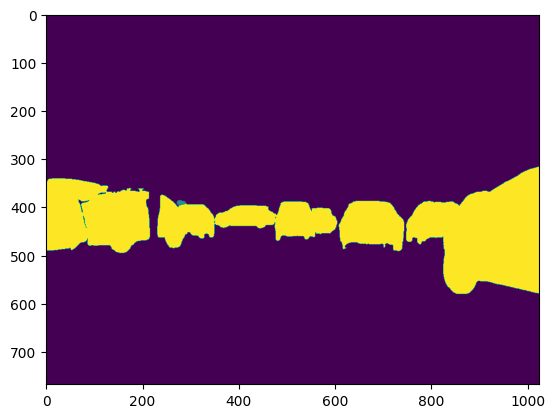

In [37]:
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt

mask = torch.tensor(np.array(Image.open('/Data3/cao/ZiHanCao/exps/Grounded-Segment-Anything/outputs/test/mask/00002.png')))
img = torch.tensor(np.array(Image.open('/Data3/cao/ZiHanCao/datasets/M3FD/M3FD_Detection/vi/00002.png')))


# plt.imshow(img[mask])

plt.imshow(mask)

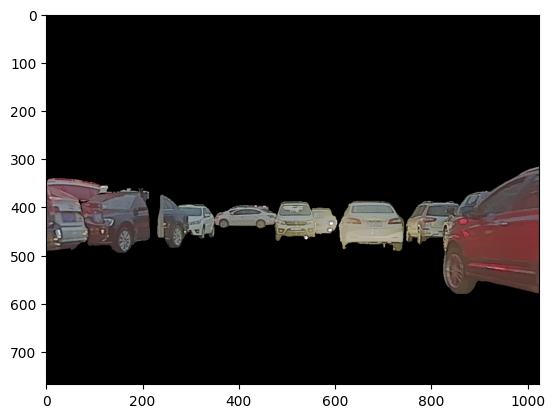

In [40]:
plt.imshow(img * (mask == 2)[...,None])

In [7]:
import numpy as np
from pathlib import Path
from PIL import Image

vi_path = Path('/Data3/cao/ZiHanCao/datasets/M3FD_Detection/vi')
mask_path = Path('/Data3/cao/ZiHanCao/exps/Grounded-Segment-Anything/outputs/test/mask')

vi_imgs = [p.name for p in vi_path.glob("*.png")]
mask_imgs = [p.name for p in mask_path.glob("*.jpg")]

print(f'number of visible images: {len(vi_imgs)}')
print(f'number of mask images: {len(mask_imgs)}')

not_exist_name = []
for vi_name in vi_imgs:
    # print(mask_p.name)
    vi_name = vi_name.replace('.png', '.jpg')
    if vi_name not in mask_imgs:
        print(f'{vi_name} not in visible images')
        not_exist_name.append(vi_name)
        
for name in not_exist_name:
    not_exist_vi = vi_path / name
    
    h, w = Image.open(not_exist_vi).size
    null_mask = np.zeros((h, w), dtype=np.uint8)
    
    # Image.fromarray(null_mask).save(mask_path / name)
    # print('save null mask for {} at {}'.format(name, mask_path / name))

number of visible images: 4200
number of mask images: 4199
01935.jpg not in visible images


FileNotFoundError: [Errno 2] No such file or directory: '/Data3/cao/ZiHanCao/datasets/M3FD_Detection/vi/01935.jpg'

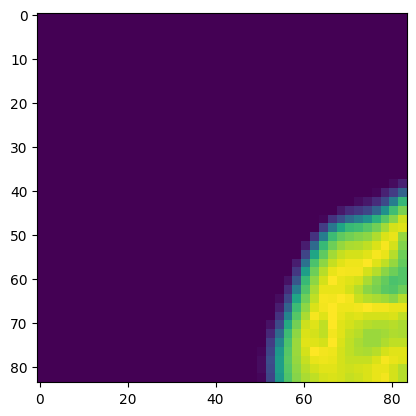

In [7]:
import h5py
import matplotlib.pyplot as plt

file = h5py.File('/Data3/cao/ZiHanCao/datasets/MedHarvard/whu/train/Medical_Dataset.h5')

data = file['data']

plt.imshow(data[0][0])
plt.imshow(data[0][1])

In [ ]:
import numpy as np
from PIL import Image

img = Image.open('/Data3/cao/ZiHanCao/exps/Grounded-Segment-Anything/outputs/train/mask/010032.jpg')
arr = np.array(img)
np.unique(arr)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
      dtype=uint8)

In [ ]:
import sys

sys.path.append('../')
from task_datasets.MedHarvard import MedHarvardDataset


ds = MedHarvardDataset(base_dir='/Data3/cao/ZiHanCao/datasets/MedHarvard', mode='test',
                           device='cuda:0')
print(ds[0])

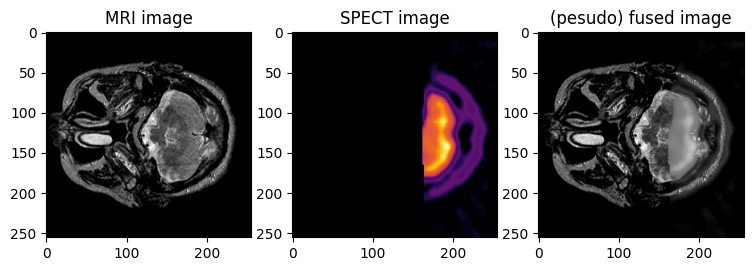

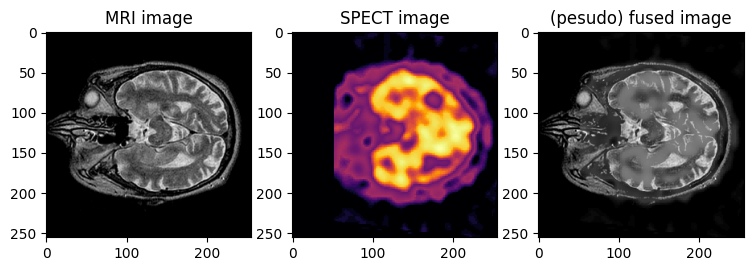

In [106]:
import torch
from torch.utils.data import DataLoader

dl = DataLoader(ds, batch_size=1, shuffle=True, num_workers=0)

index = 0
for i, (x, y) in enumerate(dl):
    fig, axes = plt.subplots(1, 3, figsize=(9, 3))
    axes[0].imshow(x[index,0].cpu().numpy(), cmap='gray')
    axes[1].imshow(y[index,0].cpu().numpy(), cmap='inferno')
    axes[2].imshow(torch.max(x, y)[index,0].cpu().numpy(), cmap='gray')
    
    axes[0].set_title('MRI image')
    axes[1].set_title('SPECT image')
    axes[2].set_title('(pesudo) fused image')
    
    if i == 1:
        break

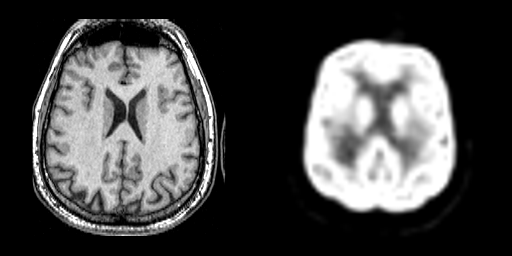

In [89]:
import cv2
from pathlib import Path

mri_path = Path('/Data3/cao/ZiHanCao/datasets/MedHarvard/whu/test/MR-T1')
pet_path = Path('/Data3/cao/ZiHanCao/datasets/MedHarvard/whu/test/PET-I')

mri_imgs = [p for p in mri_path.glob("*.png")]
pet_imgs = [p for p in pet_path.glob("*.png")]


i = 0
for mri_p, pet_p in zip(mri_imgs, pet_imgs):
    mri_img = Image.open(mri_p)#.convert('RGB')
    pet_img = Image.open(pet_p).resize(mri_img.size)
    # pesudo color pet
    # pet_img = cv2.applyColorMap(np.array(pet_img), cv2.COLORMAP_VIRIDIS)
    
    # stack the images
    fused_img = Image.fromarray(np.hstack((np.array(mri_img), np.array(pet_img))))

    i += 1
    
    if i > 7:
        break

fused_img


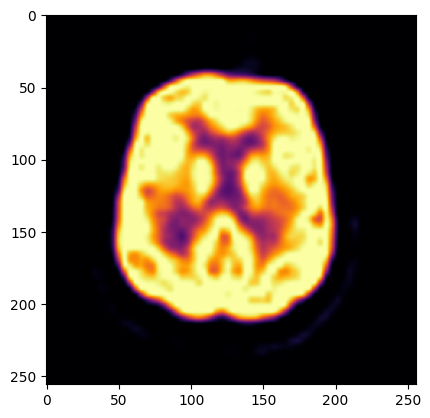

In [121]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# arr = np.array(mri_img)
arr = np.array(pet_img)

cmap = plt.cm.inferno
norm = mcolors.Normalize(vmin=arr.min(), vmax=arr.max())
colored_mri = cmap(norm(arr))

plt.imshow(colored_mri)


In [6]:
# read some files and save then into a temp zip file

import zipfile
from pathlib import Path
import logging
import numpy as np

zipf = zipfile.ZipFile('./tmp_zip.zip', 'w', compression=zipfile.ZIP_DEFLATED, compresslevel=9)

base_dir = Path('/Data3/cao/ZiHanCao/datasets/LLVIP/data/visible/test')
paths = base_dir.glob('*.jpg')
sub_file = 'vi/'
for p in list(paths)[:10]:
    with open(p, 'rb') as f:
        data = np.frombuffer(f.read(), dtype=np.uint8)
        zipf.writestr(sub_file + p.name, data.tobytes())

logging.info('zip files done.')
print(zipf.namelist())
zipf.close()

['vi/190001.jpg', 'vi/190002.jpg', 'vi/190003.jpg', 'vi/190004.jpg', 'vi/190005.jpg', 'vi/190006.jpg', 'vi/190007.jpg', 'vi/190008.jpg', 'vi/190009.jpg', 'vi/190010.jpg']


In [1]:

from contextlib import contextmanager
import zipfile
from pathlib import Path
import numpy as np
from PIL import Image
from io import BytesIO

from loguru import logger
@contextmanager

def save_result_in_zip(zipfile_name: str, 
                       mode='w', 
                       verbose: bool=False,
                       save_file_ext: str='jpeg'):
    # save_file_ext = save_file_ext.upper()
    zf = zipfile.ZipFile(zipfile_name, 
                         mode=mode,
                         compression=zipfile.ZIP_DEFLATED,
                         compresslevel=9) 
    bytes_io = BytesIO()
    
    try:
            
        logger.debug(f'zip file will be saved at {zipfile_name}')
        
        def to_bytes(image_data, image_name):
            batched_image_bytes = []
            
            if image_data.ndim == 4:  # batched rgb images
                assert isinstance(image_name, list), 'image_name should be a list'
                assert image_data.shape[0] == len(image_name), 'image_name should have the same length as image_data'
                
                for img in image_data: # [b, h, w, c]
                    Image.fromarray(img).save(bytes_io, format=save_file_ext)
                    batched_image_bytes.append(bytes_io.getvalue()) 
            elif image_data.ndim == 3:
                if image_data.shape[-1] == 1:  # gray image  # [h, w, 1]
                    Image.fromarray(image_data[..., 0]).save(bytes_io, format=save_file_ext)
                    image_data = bytes_io.getvalue()
                elif image_data.shape[-1] == 3:
                    Image.fromarray(image_data).save(bytes_io, format=save_file_ext)
                    image_data = bytes_io.getvalue()
                else:
                    raise ValueError(f"image_data shape {image_data.shape} not supported")
            elif image_data.ndim == 2:  # gray image  # [h, w]
                Image.fromarray(image_data).save(bytes_io, format=save_file_ext)
                image_data = bytes_io.getvalue()
                
            return image_data, batched_image_bytes
        
        def add_image(image_data: "Image.Image | np.ndarray | torch.Tensor | bytes", 
                        image_name: str | list[str]):
            """add image to the zipfile

            Args:
                image_data (Image.Image | np.ndarray | torch.Tensor | bytes): can be Image.Image, np.ndarray, torch.Tensor, bytes,
                                                    shape should be [b, h, w, c], [h, w, c], [h, w, 1]
                image_name (str | list[str]): saved image names
            """
            
            # to bytes
            if isinstance(image_data, Image.Image):
                image_data.save(bytes_io, format=save_file_ext)
                image_data = bytes_io.getvalue()
            elif isinstance(image_data, np.ndarray):
                bytes, batched_image_bytes = to_bytes(image_data, image_name)
            elif isinstance(image_data, torch.Tensor):
                image_data = image_data.detach().cpu().numpy()
                bytes, batched_image_bytes = to_bytes(image_data, image_name)
            else:
                raise ValueError(f"image_data type {type(image_data)} not supported")
            
            # saving to zip file
            if len(batched_image_bytes) > 0:
                for i, img_bytes in enumerate(batched_image_bytes):
                    zf.writestr(image_name[i], img_bytes)
            else:
                zf.writestr(image_name, bytes)
            
            # logger.debug('ready to verbose')
            if verbose:
                logger.info(f'add image {image_name} to zip file')
                
        yield add_image
                
    except Exception as e:
        if verbose:
            logger.exception(e)
    finally:
        if verbose:
            logger.info(f'zip file saved at {zipfile_name}, zipfile close')
        zf.close()
        bytes_io.close()

    


In [2]:
with save_result_in_zip('tmp.zip', verbose=True) as add_img:
    add_img(np.random.randint(0, 255, (64, 64, 3)).astype('uint8'), 'test/test_img.jpg')

2024-06-27 21:10:06.247 | DEBUG    | __main__:save_result_in_zip:24 - zip file will be saved at tmp.zip
2024-06-27 21:10:06.264 | INFO     | __main__:add_image:82 - add image test/test_img.jpg to zip file
2024-06-27 21:10:06.266 | INFO     | __main__:save_result_in_zip:91 - zip file saved at tmp.zip, zipfile close


In [55]:
with open('/Data3/cao/ZiHanCao/exps/panformer/test/test_img.jpg', 'rb') as f:
    data = np.frombuffer(f.read(), dtype=np.uint8)
    print(data)
data.shape

[ 65  22  99 ... 116 148   3]


(12288,)

In [48]:
# find the classes and indexs
import xml.etree.ElementTree as ET

xml_path = '/Data3/cao/ZiHanCao/datasets/M3FD/M3FD_Detection/Annotation/00000.xml'
tree = ET.parse(xml_path)

list(tree.getroot().iterfind('bndbox'))


[]

In [11]:
# mv files from Detection dir to Fusion dir in M3FD dataset

import shutil
from pathlib import Path

from tqdm import tqdm

from loguru import logger

detection_dir = Path('/Data3/cao/ZiHanCao/datasets/M3FD/M3FD_Detection')
fusion_dir = Path('/Data3/cao/ZiHanCao/datasets/M3FD/M3FD_Fusion')

detection_vi_file = [p.name for p in (detection_dir / 'vi').glob('*.*')]
logger.info(f'total detection files {len(detection_vi_file)}')

fusion_vi_file = list(fusion_dir.glob('vi/*.*'))
logger.info(f'total fusion files {len(fusion_vi_file)}')

# tbar = tqdm(fusion_vi_file, total=len(fusion_vi_file))
# for p in tbar:
#     name = p.name
#     name_wo_ext = name.split('.')[0]
#     if name in detection_vi_file:
#         # masked_img_show files
#         masked_img_show_p = detection_dir / 'masked_img_show' / f'{name_wo_ext}.jpg'
#         assert masked_img_show_p.exists()
        
#         # labels
#         label_p = detection_dir / 'labels' / f'{name_wo_ext}.txt'
#         assert label_p.exists()
        
#         # vi and ir imgs
#         vi_p = detection_dir / 'vi' / name
#         ir_p = detection_dir / 'ir' / name
#         assert vi_p.exists() and ir_p.exists()
        
#         # annotation files
#         ann_p = detection_dir / 'Annotation' / f'{name_wo_ext}.xml'
#         assert ann_p.exists()
        
#         # mask files
#         mask_p = detection_dir / 'mask' / f'{name_wo_ext}.png'
#         assert mask_p.exists()
        
#         # move files
#         shutil.move(masked_img_show_p, fusion_dir / 'masked_img_show')
#         shutil.move(label_p, fusion_dir / 'labels')
#         shutil.move(ann_p, fusion_dir / 'Annotation')
#         shutil.move(mask_p, fusion_dir / 'mask')
#         # shutil.move(vi_p, fusion_dir / 'tmp_vi')
#         # shutil.move(ir_p, fusion_dir / 'tmp_ir')
        
#         tbar.set_description(f'{name} moved')
        
#         # logger.info(masked_img_show_p)
#         # shutil.copy()
#         # break
#     else:
#         logger.warning(f'{p.name} not in Detection files')
        
logger.info('done')

2024-06-30 16:34:51.918 | INFO     | __main__:<module>:14 - total detection files 3900
2024-06-30 16:34:51.922 | INFO     | __main__:<module>:17 - total fusion files 300
2024-06-30 16:34:51.923 | INFO     | __main__:<module>:61 - done


In [ ]:
from nvidia.dali.pipeline import Pipeline
from pathlib import Path
import os
import glob
import numpy as np
import torch
from typing import Literal
from nvidia.dali import pipeline_def
import nvidia.dali.fn as fn
import nvidia.dali.types as types
    
image_dir = '/Data3/cao/ZiHanCao/datasets/LLVIP/data/visible/train'
files = glob.glob(image_dir + '/*.jpg')
labels = [os.path.basename(p) for p in files]
label_indices = np.arange(1, len(files)+1).tolist()

def common_pipeline(jpegs):
    images = fn.decoders.image(jpegs, device='mixed')
    fn.python_function(images, function=_print_shape)
    images = fn.resize(
        images,
        resize_shorter=fn.random.uniform(range=(256, 480)),
        interp_type=types.INTERP_LINEAR)
    images = fn.crop_mirror_normalize(
        images,
        crop_pos_x=fn.random.uniform(range=(0.0, 1.0)),
        crop_pos_y=fn.random.uniform(range=(0.0, 1.0)),
        dtype=types.FLOAT,
        crop=(227, 227),
        mean=[128., 128., 128.],
        std=[1., 1., 1.])
    return images

def _print_shape(x):
    print(x.shape)
    
    return x

def _to_names(index):
    # print(index)
    # print(labels[*index])
    if torch.is_tensor(index):
        index = index.cpu().numpy()
    
    index = index.tolist()
    print(f'index: {index}, type: {type(index)}')
    
    try:
        label = labels[index[0]]
        arr_name = string_to_ascii_array(label)
        print(arr_name)
    except Exception as e:
        raise e
    
    return arr_name

def string_to_ascii_array(s):
    ascii_values = [ord(char) for char in s]
    return np.array(ascii_values, dtype=np.uint8)

def ascii_tensor_to_string(ascii_tensor):
    ascii_array = ascii_tensor.detach().cpu().numpy()
    
    string_s = []
    for arr in ascii_array:
        characters = [chr(code) for code in arr]
        string_s.append(''.join(characters))
        
    return string_s

@pipeline_def(num_threads=2)
def file_reader_pipeline(num_gpus):
    jpegs, indices = fn.readers.file(
        # file_root=image_dir,
        files=files,
        labels=label_indices,
        random_shuffle=True,
        shard_id=0,
        num_shards=1,
        name='Reader',
    )
    name = fn.python_function(indices, function=_to_names)

    return common_pipeline(jpegs), name

pipe = file_reader_pipeline(num_gpus=1, batch_size=12, device_id=0)
pipe.build()
data = pipe.run()

data

In [21]:
import zipfile
from io import BytesIO
from contextlib import contextmanager

from utils import save_imgs_in_zip, EasyProgress, easy_logger
logger = easy_logger()


@contextmanager
def save_imgs_in_zip(
    zipfile_name: str, mode="w", verbose: bool = False, save_file_ext: str = "jpeg"
):
    # save_file_ext = save_file_ext.upper()
    zf = zipfile.ZipFile(
        zipfile_name, mode=mode, compression=zipfile.ZIP_DEFLATED, compresslevel=9
    )
    bytes_io = BytesIO()

    try:

        logger.info(f"zip file will be saved at {zipfile_name}")

        def to_bytes(image_data, image_name):
            batched_image_bytes = []

            if image_data.ndim == 4:  # batched rgb images
                assert isinstance(image_name, list), "image_name should be a list"
                assert image_data.shape[0] == len(
                    image_name
                ), "image_name should have the same length as image_data"

                for img in image_data:  # [b, h, w, c]
                    Image.fromarray(img).save(bytes_io, format=save_file_ext)
                    batched_image_bytes.append(bytes_io.getvalue())
            elif image_data.ndim == 3:
                if image_data.shape[-1] == 1:  # gray image  # [h, w, 1]
                    Image.fromarray(image_data[..., 0]).save(
                        bytes_io, format=save_file_ext
                    )
                    image_data = bytes_io.getvalue()
                elif image_data.shape[-1] == 3:
                    Image.fromarray(image_data).save(bytes_io, format=save_file_ext)
                    image_data = bytes_io.getvalue()
                else:
                    raise ValueError(
                        f"image_data shape {image_data.shape} not supported"
                    )
            elif image_data.ndim == 2:  # gray image  # [h, w]
                Image.fromarray(image_data).save(bytes_io, format=save_file_ext)
                image_data = bytes_io.getvalue()

            return image_data, batched_image_bytes

        def add_image(
            image_data: "Image.Image | np.ndarray | torch.Tensor | bytes",
            image_name,
        ):
            """add image to the zipfile

            Args:
                image_data (Image.Image | np.ndarray | torch.Tensor | bytes): can be Image.Image, np.ndarray, torch.Tensor, bytes,
                                                    shape should be [b, h, w, c], [h, w, c], [h, w, 1]
                image_name (str | list[str]): saved image names
            """

            # to bytes
            batched_image_bytes = None
            if isinstance(image_data, Image.Image):
                image_data.save(bytes_io, format=save_file_ext)
                bytes = bytes_io.getvalue()
            elif isinstance(image_data, np.ndarray):
                bytes, batched_image_bytes = to_bytes(image_data, image_name)
            elif isinstance(image_data, torch.Tensor):
                image_data = image_data.detach().cpu().numpy()
                bytes, batched_image_bytes = to_bytes(image_data, image_name)
            else:
                raise ValueError(f"image_data type {type(image_data)} not supported")

            # saving to zip file
            if batched_image_bytes is not None:
                for i, img_bytes in enumerate(batched_image_bytes):
                    zf.writestr(image_name[i], img_bytes)
            else:
                zf.writestr(image_name, bytes)

            if verbose:
                logger.info(f"add image {image_name} to zip file")

        yield add_image

    except Exception as e:
        if verbose:
            logger.error(e, raise_error=True)
            raise e
    finally:
        if verbose:
            logger.info(f"zip file saved at {zipfile_name}, zipfile close")
        zf.close()
        bytes_io.close()
        

In [ ]:
import sys
sys.path.append('../')

from pathlib import Path

from PIL import Image

vi_path = Path('/Data3/cao/ZiHanCao/datasets/MSRS/train/vi')
img_paths = list(vi_path.glob('*.png'))
tbar, task = EasyProgress.easy_progress(['save images in zip'], [len(img_paths)])

tbar.start()
with save_imgs_in_zip('vi_jpg.zip', verbose=False) as add_img:
    for p in img_paths:
        img = Image.open(p)
        add_img(img, p.name.replace('.png', '.jpg'))
        tbar.update(task, advance=1, total=len(img_paths))

In [ ]:
import re
from pathlib import Path

from rich.jupyter import print

dt_path = Path('/Data3/cao/ZiHanCao/datasets/MSRS/detection/vi')
assert dt_path.exists()

img_paths = list(dt_path.glob('*.png'))
print(f'found detection files {len(img_paths)}')

train_vi_dir = Path('/Data3/cao/ZiHanCao/datasets/MSRS/train/vi')
test_vi_dir = Path('/Data3/cao/ZiHanCao/datasets/MSRS/test/vi')

num_pattern = re.compile(r'\d+')

def file_name_to_int(name):
    find_str = num_pattern.findall(name)
    assert len(find_str) == 1

    n = int(find_str[0])
    return n


# process into integer num
train_file_int = {str(file_name_to_int(p.name)): p.parents[2] / 'Segmentation_labels' / (p.name.split('.')[0] + '.png') for p in train_vi_dir.glob('*.jpg')}
test_file_int = {str(file_name_to_int(p.name)): p.parents[2] / 'Segmentation_labels' / (p.name.split('.')[0] + '.png') for p in test_vi_dir.glob('*.jpg')}

# merge two dict
all_file_int = {}
all_file_int.update(train_file_int)
all_file_int.update(test_file_int)

print(f'found train and test files {len(all_file_int)}')

del train_file_int, test_file_int

# copy mask files to detection dir
for p in img_paths:
    n = file_name_to_int(p.name)
    
    try:
        mask_path = all_file_int[str(n)]
    except Exception as e:
        print(f'got no detection file {p.name}')
        continue



In [32]:
import numpy as np
from pathlib import Path
from rich.jupyter import print

relative_path = '/Data3/cao/ZiHanCao/datasets/MedHarvard/xmu/'
base_dir = Path('/Data3/cao/ZiHanCao/datasets/MedHarvard/xmu/CT-MRI')

mri_dir = base_dir / 'MRI'
spect_dir = base_dir / 'CT'

mri_img_paths = list(mri_dir.glob('*.png'))
spect_img_paths = list(spect_dir.glob('*.png'))
print('has MRI images: ', len(mri_img_paths))

n_train = int(len(mri_img_paths) * 0.8)
n_test = len(mri_img_paths) - n_train
print('train: ', n_train)
print('test: ', n_test)

mri_img_paths[0].absolute()

to_str = lambda list_posix_path: [p.relative_to(base_dir).as_posix() for p in list_posix_path]

perm_ = np.random.permutation(len(mri_img_paths))
train_perm = perm_[:n_train]
test_perm = perm_[n_train:]

train_paths_mri = to_str(np.array(mri_img_paths)[train_perm])
train_paths_spect = to_str(np.array(spect_img_paths)[train_perm])
test_paths_mri = to_str(np.array(mri_img_paths)[test_perm])
test_paths_spect = to_str(np.array(spect_img_paths)[test_perm])

train_arr = np.stack([np.arange(n_train), train_paths_mri, train_paths_spect], axis=1)
test_arr = np.stack([np.arange(n_test), test_paths_mri, test_paths_spect], axis=1)

with open(base_dir / 'train.txt', 'w') as f:
    np.savetxt(f, train_arr, delimiter=' ', fmt='%s')
print(f'train txt saved')
    
with open(base_dir / 'test.txt', 'w') as f:
    np.savetxt(f, test_arr, delimiter=' ', fmt='%s')
print(f'test txt saved')


has MRI images:  184

train:  147

test:  37

train txt saved

test txt saved

In [16]:
import os
import numpy as np
from pathlib import Path
import shutil
# from rich.jupyter import print


base_dir = Path('/Data3/cao/ZiHanCao/datasets/MedHarvard/xmu')
task = 'CT-MRI'
modals = task.split('-')

train_file = np.loadtxt(base_dir / task / 'train.txt', delimiter=' ', dtype='U15')
test_file = np.loadtxt(base_dir / task / 'test.txt', delimiter=' ', dtype='U15')

train_dir = base_dir / task / 'train'
test_dir = base_dir / task / 'test'

for i, d in enumerate([train_dir, test_dir]):
    for m in modals:
        (d / m).mkdir(parents=True, exist_ok=True)
        
    for idx, s1, s2 in [train_file, test_file][i]:
        dest_m0 = d / modals[1] / os.path.basename(str(s1))
        dest_m1 = d / modals[0] / os.path.basename(str(s2))
        
        shutil.copy(base_dir / task / s1, dest_m0)
        shutil.copy(base_dir / task / s2, dest_m1)
        
        print(f'move files from {s1} -> {dest_m0.relative_to(base_dir)}, {s2} -> {dest_m1.relative_to(base_dir)}')


move files from MRI/16016.png -> CT-MRI/train/MRI/16016.png, CT/16016.png -> CT-MRI/train/CT/16016.png
move files from MRI/32007.png -> CT-MRI/train/MRI/32007.png, CT/32007.png -> CT-MRI/train/CT/32007.png
move files from MRI/20010.png -> CT-MRI/train/MRI/20010.png, CT/20010.png -> CT-MRI/train/CT/20010.png
move files from MRI/2015.png -> CT-MRI/train/MRI/2015.png, CT/2015.png -> CT-MRI/train/CT/2015.png
move files from MRI/2014.png -> CT-MRI/train/MRI/2014.png, CT/2014.png -> CT-MRI/train/CT/2014.png
move files from MRI/32017.png -> CT-MRI/train/MRI/32017.png, CT/32017.png -> CT-MRI/train/CT/32017.png
move files from MRI/37010.png -> CT-MRI/train/MRI/37010.png, CT/37010.png -> CT-MRI/train/CT/37010.png
move files from MRI/33006.png -> CT-MRI/train/MRI/33006.png, CT/33006.png -> CT-MRI/train/CT/33006.png
move files from MRI/16019.png -> CT-MRI/train/MRI/16019.png, CT/16019.png -> CT-MRI/train/CT/16019.png
move files from MRI/16014.png -> CT-MRI/train/MRI/16014.png, CT/16014.png -> CT-M

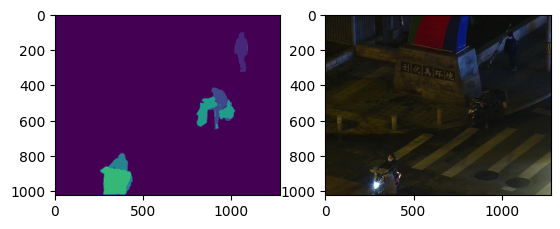

In [4]:
import numpy as np
from torchvision.io import read_image
import matplotlib.pyplot as plt
import torch

path = '/Data3/cao/ZiHanCao/datasets/LLVIP/data/instance_mask/train/010014.jpg'
mask = read_image(path)

path = '/Data3/cao/ZiHanCao/datasets/LLVIP/data/visible/train/010014.jpg'
vi = read_image(path)

plt.subplot(1, 2, 1)
plt.imshow(mask[0])

plt.subplot(1, 2, 2)
plt.imshow(vi.permute(1, 2, 0))


In [9]:
# check if has full data matched (mask and images)

from pathlib import Path
import numpy as np
import PIL.Image as Img

img_path = Path('/Data3/cao/ZiHanCao/datasets/LLVIP/data/visible/test')
mask_path = Path('/Data3/cao/ZiHanCao/datasets/LLVIP/data/mask/test')

for p in img_path.glob('*.jpg'):
    mask_p = mask_path / (p.stem + '.png')
    if not mask_p.exists():
        print(f'{mask_p} not exists')
        img = Img.open(p)
        print(f'has img size {img.size}')
        mask = Img.fromarray(
            np.zeros((img.size[1], img.size[0]), dtype=np.uint8)
        )
        mask.save(mask_p)
        print('save null mask\n')
        

In [24]:
## find training set for MEF-MEFB dataset

import numpy as np
from pathlib import Path

test_set = np.loadtxt('/Data3/cao/ZiHanCao/datasets/MEF-MEFB/test.txt', dtype=np.unicode_)
path = Path('/Data3/cao/ZiHanCao/datasets/MEF-MEFB/OVER')

cnt = 0
test_cnt = 0
train_lst = []
for p in path.glob('*.*'):
    if p.name not in test_set.tolist():
        # print(p.name)
        train_lst.append(p.name)
        cnt += 1
    elif p.name in test_set.tolist():
        test_cnt += 1
        
print(f'test set has {test_cnt} images')
print(f'training set has {cnt} images')

# for name in test_set:
#     if not (path / name).exists():
#         print(f'{name} not exists')



test set has 40 images
training set has 60 images


In [28]:
np.savetxt('/Data3/cao/ZiHanCao/datasets/MEF-MEFB/train.txt', train_lst, fmt='%s')

In [4]:
import os
import cv2
from pathlib import Path

path = Path('/Data3/cao/ZiHanCao/exps/panformer/visualized_img/panRWKV_v3/msrs')

for p in path.glob('*.png'):
    try:
        img = cv2.imread(str(p))
        img.shape
    except:
        print(p.name)
    




00047N.png
